In [1]:
# Importing necessary libraries
import numpy as np

import time 

from tqdm.notebook import tqdm

from IPython.display import HTML
from IPython.display import Video
# Also ffmpeg is required for video saving
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation

# Importing custom modules
from engine_DP import CoinGame
from agent_DP import RandomAgent, IndQLearningAgentSoftmax, Level1QAgent, Level2QAgent, Level2QAgentSoftmax, Level1DPAgent, Level1DPAgent_Stationary
# from agent_DP import ExpSmoother, FPLearningAgent, Level2QAgent, RandomAgent, IndQLearningAgent, Level3QAgent, Level3QAgentMixExp, Level3QAgentMixDir

In [2]:
def moving_average(a, n=3):
    """
    Compute the simple moving average of a 1D array.

    Parameters:
        a (array-like): Input array containing numerical data.
        n (int, optional): Window size for the moving average. Defaults to 3.

    Returns:
        ndarray: Array of moving averages with length len(a) - n + 1.
    """
    # Compute cumulative sum of the input array as float
    ret = np.cumsum(a, dtype=float)
    
    # Subtract the cumulative sum shifted by 'n' to get the sum over each window
    ret[n:] = ret[n:] - ret[:-n]
    
    # Divide by window size to obtain the moving average
    return ret[n - 1:] / n

def plot(r0ss, r1ss, moving_average_window_size=1000, dir=None):
    """
    Plot smoothed reward trajectories for two agents over multiple experiments.

    Parameters:
        r0ss (list of arrays): Rewards for Agent A across experiments.
        r1ss (list of arrays): Rewards for Agent B across experiments.
        dir (str, optional): If provided, saves the plot to 'dir.png'.

    Returns:
        None
    """
    # Apply 'ggplot' style for aesthetics
    plt.style.use('ggplot')

    N_EXP = len(r0ss)  # Number of experiments

    # Plot individual experiment trajectories with low opacity
    for i in range(N_EXP):
        plt.plot(moving_average(r0ss[i], moving_average_window_size), 'b', alpha=0.05)
        plt.plot(moving_average(r1ss[i], moving_average_window_size), 'r', alpha=0.05)

    # Plot average trajectory across experiments with higher opacity
    plt.plot(moving_average(np.mean(r0ss, axis=0), moving_average_window_size), 'b', alpha=0.5)
    plt.plot(moving_average(np.mean(r1ss, axis=0), moving_average_window_size), 'r', alpha=0.5)

    # Label axes
    plt.xlabel('t')
    plt.ylabel('R')

    # Create custom legend
    custom_lines = [Line2D([0], [0], color='b', label='Agent A'),
                    Line2D([0], [0], color='r', label='Agent B')]
    plt.legend(handles=custom_lines)

    # Save plot if directory is specified
    if dir is not None:
        plt.savefig(f"{dir}.png")

In [3]:
def animate_trajectory_from_log(trajectory_log, grid_size=4, fps=4, dpi=100):
    """
    Animate a trajectory from an enriched trajectory log that includes actions and rewards.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(-0.5, grid_size - 0.5)
    ax.set_ylim(-0.5, grid_size - 0.5)
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.set_aspect('equal')
    ax.grid(True)

    title = ax.set_title("")
    
    info_text = fig.text(0.02, 0.5, "", ha='left', va='center', fontsize=10)
    
    move_action_codes = ["Down", "Right", "Up", "Left"]
    action_push_codes = ["No push", "Push"]

    # Agent and coin markers
    dm_dot, = ax.plot([], [], 'bo', label='DM (Blue)')
    adv_dot, = ax.plot([], [], 'ro', label='Adv (Red)')
    coin1_dot, = ax.plot([], [], 'y*', label='Coin 1', markersize=15)
    coin2_dot, = ax.plot([], [], 'g*', label='Coin 2', markersize=15)

    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    def init():
        dm_dot.set_data([], [])
        adv_dot.set_data([], [])
        coin1_dot.set_data([], [])
        coin2_dot.set_data([], [])
        title.set_text("")
        return dm_dot, adv_dot, coin1_dot, coin2_dot, title

    def update(frame):
        state = trajectory_log[frame]

        
        if isinstance(state['DM_location_new'], (list, np.ndarray)) and len(state['DM_location_new']) == 2:
            dm_dot.set_data([state['DM_location_new'][1]], [state['DM_location_new'][0]])
        else:
            dm_dot.set_data([], [])

        if isinstance(state['Adv_location_new'], (list, np.ndarray)) and len(state['Adv_location_new']) == 2:
            adv_dot.set_data([state['Adv_location_new'][1]], [state['Adv_location_new'][0]])
        else:
            adv_dot.set_data([], [])

        if isinstance(state['coin1'], (list, np.ndarray)) and len(state['coin1']) == 2:
            coin1_dot.set_data([state['coin1'][1]], [state['coin1'][0]])
        else:
            coin1_dot.set_data([-10], [-10])  # hide

        if isinstance(state['coin2'], (list, np.ndarray)) and len(state['coin2']) == 2:
            coin2_dot.set_data([state['coin2'][1]], [state['coin2'][0]])
        else:
            coin2_dot.set_data([-10], [-10])  # hide

        title.set_text(
            f"Exp {state['experiment']} | Ep {state['epoch']} | Step {frame}"
        )
        
       
        if(np.array_equal(state['action_DM'], ["None", "None"])): 
            DM_action_string = ["None", "None"]
        else: 
            DM_action_string = f"DM Action: [{move_action_codes[state['action_DM'][0]]}, {action_push_codes[state['action_DM'][1]]}]"
            
        if(np.array_equal(state['action_DM'], ["None", "None"])): 
            Adv_action_string = ["None", "None"]
        else: 
            Adv_action_string = f"Adv Action: [{move_action_codes[state['action_Adv'][0]]}, {action_push_codes[state['action_Adv'][1]]}]"
            
        # Update a text box the grid for step and reward info
        info_text.set_text(
            (
                f"Previous state DM: [{state['DM_location_old'][0]}, {state['DM_location_old'][1]}]\n"
                f"New State DM: [{state['DM_location_new'][0]}, {state['DM_location_new'][1]}]\n"
                f"{DM_action_string}\n"
                f"DM reward: {state['reward_DM']}\n"
                f"\n"  # This adds a visual separation
                f"Previous state Adv: [{state['Adv_location_old'][0]}, {state['Adv_location_old'][1]}]\n"
                f"New State Adv: [{state['Adv_location_new'][0]}, {state['Adv_location_new'][1]}]\n"
                f"{Adv_action_string}\n"
                f"Adv reward: {state['reward_Adv']}"
            )
        )

        return dm_dot, adv_dot, coin1_dot, coin2_dot, title

    ani = animation.FuncAnimation(
        fig, update,
        frames=len(trajectory_log),
        init_func=init,
        blit=False,
        repeat=False
    )
    ani.save("trajectory.mp4", writer="ffmpeg", fps=fps, dpi=dpi)
    plt.close(fig)

## Experiment setup

In [ ]:
## Setup experiment 1

# Number of experiments
N_EXP = 1

# Size of single dimension of the square grid
grid_size = 7

# Initialize environment 
env = CoinGame(max_steps=2000, size_square_grid=grid_size, push_distance=2)

# Number of states 
n_states = env.n_states

# Number of episodes 
n_iter = 5000

# Constant gamma 
gamma = 0.95

# Learning rate
learning_rate = 0.5

# Epsilon for epsilon greedy policy
epsilon = 0.3

# Moving average window size for plotting 
moving_average_window_size = 500

r0ss = []
r1ss = []

0


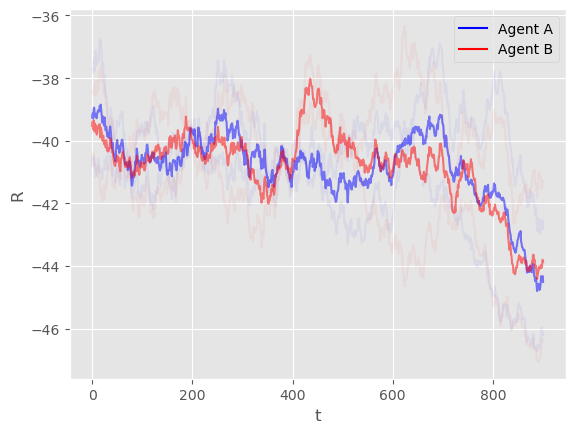

In [9]:
# Run the experiments
for n in range(N_EXP):
    
    ## Initialize agents
    # TODO: Add reset method to individual agents and move them to initialization
    #* Note: The agent's here are reinitialized, instead reset can be done by reseting the Q matrix inside the agent.

    # TODO: Change the actions pace to something more general
    P2 = IndQLearningAgentSoftmax(np.array(range(8)), n_states, learning_rate=learning_rate,
                           epsilon=epsilon, gamma=gamma, enemy_action_space=None, beta = 1)
    P1 = IndQLearningAgentSoftmax(np.array(range(8)), n_states, learning_rate=learning_rate,
                           epsilon=epsilon, gamma=gamma, enemy_action_space=None, beta = 1)

    # P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.7)
    # P2 = RandomAgent( env.available_actions, p=0.5)
    # P1 = Level2QAgentSoftmax(env.available_actions_DM, env.available_actions_Adv, n_states=n_states,
    #                   learning_rate=.9, epsilon=0.1, gamma=gamma)

    
    # Reset the reward vectors for the experiment
    r0s = []
    r1s = []
    
    # Run through episodes
    for i in range(n_iter):

        # Initialize the end of episode flag
        done = False
        # Reset the environment after each episode
        env.reset()
        # Get the initial state
        s = env.get_state()
        
        # Initialize cummulative observed rewards for this episode
        episode_rewards_DM = 0
        episode_rewards_Adv = 0
        
        # While the agents have not reached the terminal state
        while not done:
            # Agents choose actions 
            # * Note: They choose the actions simultaneously
            a1 = P1.act(obs=s, env=None)
            a2 = P2.act(obs=s, env=None)

            # Transition to next time step
            s_new, rewards, done =  env.step([a1,a2])

            # Agents update their Q/Value functions
            # * Note: They update their Q/Value functions simultaneously
            P1.update(s, [a1, a2], [rewards[0], rewards[1]], s_new, env=None)
            P2.update(s, [a2, a1], [rewards[1], rewards[0]], s_new, env=None)
            
            # Set the current state to the new state
            s = s_new  
            
            # Add the observed reward to the episode reward of both agents 
            # * Note: The rewards are observed simultaneously
            episode_rewards_DM += rewards[0]
            episode_rewards_Adv += rewards[1]
            
        # Append the episode rewards to the list of rewards for this experiment
        r0s.append(episode_rewards_DM)
        # Append the episode rewards to the list of rewards for this experiment
        r1s.append(episode_rewards_Adv)
        
        env.reset()
        # if i%10 == 0:
        #     P1.epsilon *= 0.995
        #     P2.epsilon *= 0.995
    
          
        
    print(n)
    r0ss.append(r0s)
    r1ss.append(r1s)
    
plot(r0ss, r1ss, moving_average_window_size=moving_average_window_size, dir=None)

Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

Epochs (Exp 1):   0%|          | 0/5000 [00:00<?, ?it/s]

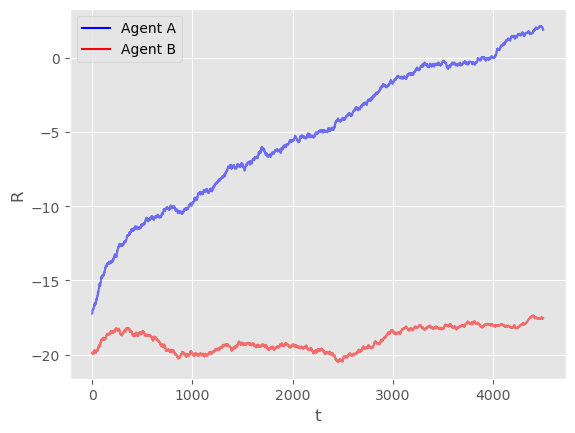

In [7]:
r0ss = []
r1ss = []

# Total trajectory logs for all experiments
trajectory_logs_all_experiments = []

# Run the experiments
for n in tqdm(range(N_EXP), desc="Experiments"):
    
    ## Initialize agents
    # TODO: Add reset method to individual agents and move them to initialization
    #* Note: The agent's here are reinitialized, instead reset can be done by reseting the Q matrix inside the agent.

    P2 = IndQLearningAgentSoftmax(np.array(range(8)), n_states, learning_rate=learning_rate,
                           epsilon=epsilon, gamma=gamma, enemy_action_space=None, beta = 1)
    # P1 = IndQLearningAgentSoftmax(env.available_actions_DM, n_states, learning_rate=.5,
    #                       epsilon=0.1, gamma=gamma, enemy_action_space=None)

    # P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.7)
    # P2 = RandomAgent( env.available_actions, p=0.5)
    
    P1 = Level2QAgent(np.array(range(8)), np.array(range(8)), n_states=n_states,
                            learning_rate=learning_rate, epsilon=epsilon, gamma=gamma)

    # P1 = Level2QAgentSoftmax(np.array(range(8)), np.array(range(8)), n_states=n_states,
    #                     learning_rate=learning_rate, epsilon=epsilon, gamma=gamma, beta=2)
    
    # Reset the reward vectors for the experiment
    r0s = []
    r1s = []
    
    # Trajectory logs for visualization
    trajectory_logs_single_experiment = []
    
    # Run through episodes
    for i in tqdm(range(n_iter), desc=f"Epochs (Exp {n+1})"):

        # Initialize the end of episode flag
        done = False
        # Reset the environment after each episode
        env.reset()
        # Get the initial state
        s = env.get_state()
        # Trajectory log for this episode
        trajectory_log_single_epoch = []
        
        # Log the initial state immediately after env.reset()
        trajectory_log_single_epoch.append({
            'DM_location_old': ["None", "None"],
            'Adv_location_old': ["None", "None"],
            'DM_location_new': env.blue_player.copy(),
            'Adv_location_new': env.red_player.copy(),
            'coin1': env.coin_1.copy() if env.coin1_available else None,
            'coin2': env.coin_2.copy() if env.coin2_available else None, 
            'action_DM': ["None", "None"],
            'action_Adv': ["None", "None"],
            'reward_DM': None,
            'reward_Adv': None,
            'state': s, 
            'experiment': n,
            'epoch': i
        })

        # Initialize cummulative observed rewards for this episode
        episode_rewards_DM = 0
        episode_rewards_Adv = 0
        
        # While the agents have not reached the terminal state
        while not done:
            # Agents choose actions 
            # * Note: They choose the actions simultaneously
            a1 = P1.act(obs=s, env=None)
            a2 = P2.act(obs=s, env=None)
            
            # Save locations for logging before a step is made
            DM_location_old = env.blue_player.copy()
            Adv_location_old = env.red_player.copy()
            
            # Transition to next time step
            s_new, rewards, done =  env.step([a1,a2])

            # Agents update their Q/Value functions
            # * Note: They update their Q/Value functions simultaneously
            P1.update(s, [a1, a2], [rewards[0], rewards[1]], s_new)
            P2.update(s, [a2, a1], [rewards[1], rewards[0]], s_new)
            
            # Set the current state to the new state
            s = s_new  
            
            # Add the observed reward to the episode reward of both agents 
            # * Note: The rewards are observed simultaneously
            episode_rewards_DM += rewards[0]
            episode_rewards_Adv += rewards[1]
        
            # Log state in single episode
            trajectory_log_single_epoch.append({
                'DM_location_old': DM_location_old,
                'Adv_location_old': Adv_location_old,
                'DM_location_new': env.blue_player.copy(),
                'Adv_location_new': env.red_player.copy(),
                'coin1': env.coin_1.copy() if env.coin1_available else None,
                'coin2': env.coin_2.copy() if env.coin2_available else None, 
                'action_DM': env.combined_actions_blue[a1],
                'action_Adv': env.combined_actions_red[a2],
                'reward_DM': rewards[0],
                'reward_Adv': rewards[1],
                'experiment': n,
                'epoch': i
            })
            
        # Append the episode rewards to the list of rewards for this experiment
        r0s.append(episode_rewards_DM)
        # Append the episode rewards to the list of rewards for this experiment
        r1s.append(episode_rewards_Adv)
        
        # Append the trajectory log for this epoch to experiment log 
        trajectory_logs_single_experiment.append(trajectory_log_single_epoch)
        
    # Append the trajectory logs of this experiment to the total logs
    trajectory_logs_all_experiments.append(trajectory_logs_single_experiment)
    
    env.reset() # Reset the environment at the very end
    
    r0ss.append(r0s)
    r1ss.append(r1s)


plot(r0ss, r1ss, moving_average_window_size=moving_average_window_size)

In [ ]:
r0ss = []
r1ss = []

# Epsilon is set to 1 in this experiment and decays with a decay parameter
epsilon = 1

# Total trajectory logs for all experiments
trajectory_logs_all_experiments = []

# Run the experiments
for n in tqdm(range(N_EXP), desc="Experiments"):
    
    ## Initialize agents
    # TODO: Add reset method to individual agents and move them to initialization
    #* Note: The agent's here are reinitialized, instead reset can be done by reseting the Q matrix inside the agent.

    P2 = IndQLearningAgentSoftmax(np.array(range(8)), n_states, learning_rate=learning_rate,
                           epsilon=epsilon, gamma=gamma, enemy_action_space=None, beta = 1)
    
    # P2 = Level2QAgent(np.array(range(8)), np.array(range(8)), n_states=n_states,
    #                     learning_rate=learning_rate, epsilon=epsilon, gamma=gamma)
    
    # P2 = Level1QAgent(np.array(range(8)), np.array(range(8)), n_states=n_states,
    #                 learning_rate=learning_rate, epsilon=epsilon, gamma=gamma)

    # P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.7)
    # P2 = RandomAgent( env.available_actions, p=0.5)
    
    P1 = Level1DPAgent_Stationary(action_space=np.array(range(len(env.combined_actions_blue))),
                   enemy_action_space=np.array(range(len(env.combined_actions_red))),
                   n_states=n_states,
                   epsilon=epsilon,
                   gamma=gamma,
                   env=env)      

    # P1 = Level2QAgentSoftmax(np.array(range(8)), np.array(range(8)), n_states=n_states,
    #                     learning_rate=learning_rate, epsilon=epsilon, gamma=gamma, beta=2)
    
    # Reset the reward vectors for the experiment
    r0s = []
    r1s = []
    
    # Trajectory logs for visualization
    trajectory_logs_single_experiment = []
    
    # Run through episodes
    for i in tqdm(range(n_iter), desc=f"Epochs (Exp {n+1})"):

        # Initialize the end of episode flag
        done = False
        # Reset the environment after each episode
        env.reset()
        # Get the initial state
        s = env.get_state()
        # Trajectory log for this episode
        trajectory_log_single_epoch = []
        
        # Log the initial state immediately after env.reset()
        trajectory_log_single_epoch.append({
            'DM_location_old': ["None", "None"],
            'Adv_location_old': ["None", "None"],
            'DM_location_new': env.blue_player.copy(),
            'Adv_location_new': env.red_player.copy(),
            'coin1': env.coin_1.copy() if env.coin1_available else None,
            'coin2': env.coin_2.copy() if env.coin2_available else None, 
            'action_DM': ["None", "None"],
            'action_Adv': ["None", "None"],
            'reward_DM': None,
            'reward_Adv': None,
            'state': s, 
            'experiment': n,
            'epoch': i
        })

        # Initialize cummulative observed rewards for this episode
        episode_rewards_DM = 0
        episode_rewards_Adv = 0
        
        # While the agents have not reached the terminal state
        while not done:
            # Agents choose actions 
            # * Note: They choose the actions simultaneously
            a1 = P1.act(obs=s, env=env)
            a2 = P2.act(obs=s, env=None)
            
            # Save locations for logging before a step is made
            DM_location_old = env.blue_player.copy()
            Adv_location_old = env.red_player.copy()
            
            # DP agent performs update before next state is evaluated
            P1.update(s, [a1, a2], rewards=None, new_obs=None, env=env)
        
            # Transition to next time step
            s_new, rewards, done =  env.step([a1,a2])

            # Update the Q matrix of adversary
            P2.update(s, [a2, a1], [rewards[1], rewards[0]], s_new, env=None)
            
            # Set the current state to the new state
            s = s_new  
            
            # Add the observed reward to the episode reward of both agents 
            # * Note: The rewards are observed simultaneously
            episode_rewards_DM += rewards[0]
            episode_rewards_Adv += rewards[1]
        
            # Log state in single episode
            trajectory_log_single_epoch.append({
                'DM_location_old': DM_location_old,
                'Adv_location_old': Adv_location_old,
                'DM_location_new': env.blue_player.copy(),
                'Adv_location_new': env.red_player.copy(),
                'coin1': env.coin_1.copy() if env.coin1_available else None,
                'coin2': env.coin_2.copy() if env.coin2_available else None, 
                'action_DM': env.combined_actions_blue[a1],
                'action_Adv': env.combined_actions_red[a2],
                'reward_DM': rewards[0],
                'reward_Adv': rewards[1],
                'experiment': n,
                'epoch': i
            })
            
        # Append the episode rewards to the list of rewards for this experiment
        r0s.append(episode_rewards_DM)
        # Append the episode rewards to the list of rewards for this experiment
        r1s.append(episode_rewards_Adv)
        
        # Append the trajectory log for this epoch to experiment log 
        trajectory_logs_single_experiment.append(trajectory_log_single_epoch)
        
        # After an epoch apply decay to exploration parameter
        P1.epsilon = P1.epsilon*0.9997
        P2.epsilon = P2.epsilon*0.9997
        
        # P2.epsilonA = P2.epsilonA*0.9997
        # P2.enemy.epsilon = P2.enemy.epsilon
        
    # Append the trajectory logs of this experiment to the total logs
    trajectory_logs_all_experiments.append(trajectory_logs_single_experiment)
    
    env.reset() # Reset the environment at the very end

    r0ss.append(r0s)
    r1ss.append(r1s)


plot(r0ss, r1ss, moving_average_window_size=moving_average_window_size)

Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

Epochs (Exp 1):   0%|          | 0/5000 [00:00<?, ?it/s]

In [15]:
experiment_num_to_display = 0
epoch_idx_to_display = 100
animate_trajectory_from_log(trajectory_logs_all_experiments[experiment_num_to_display][epoch_idx_to_display][:len(trajectory_logs_all_experiments[experiment_num_to_display][epoch_idx_to_display])], grid_size=grid_size, fps=1, dpi=100)

In [16]:
Video(url="trajectory.mp4?cache=" + str(time.time()), embed=False)